# Captcha recognition with Deep learning

In [1]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Reshape
from keras.layers import Activation, Dropout, AveragePooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.losses import mean_squared_error
import PIL
import matplotlib.pyplot as plt
import numpy
from matplotlib.pyplot import imshow,figure, imshow, axis
from matplotlib.image import imread
from image import ImageCaptcha
import os
import sys
%matplotlib inline
numpy.set_printoptions(precision=2)

Using TensorFlow backend.


In [19]:
img_width, img_height = 110, 40
epochs = 100
batch_size = 64
digit_width = 20
digit_height = 40

alpha_conf = 1
alpha_class = 1
alpha_shift = 1

positions = 13

In [3]:
image = ImageCaptcha(width=img_width, height=img_height, font_sizes=[40, 30], fonts=[
    "/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf", 
    "/usr/share/fonts/truetype/dejavu/DejaVuSansMono-BoldOblique.ttf",
    "/usr/share/fonts/truetype/ubuntu-font-family/UbuntuMono-R.ttf",
    "/usr/share/fonts/truetype/ubuntu-font-family/UbuntuMono-BI.ttf",
])
position_width = img_width/positions
def myGenerator(batch_size, digit_out = 0):
    digits = 3
    def calc(p, b, d, batch_labels, batch_index):
        position_center = position_width*p + position_width/2
        digit_offset = numpy.array(b) - position_center
        nearest_digit = numpy.argmin(numpy.abs(digit_offset))
        nearest_offset = digit_offset[nearest_digit]
        if -position_width < nearest_offset < position_width:
            v = 1
        else:
            v = 0
        dx = 0.5+(nearest_offset)/position_width/2
        dx = numpy.clip(dx, 0, 1)
            
        batch_labels[batch_index][p][0] = v
        batch_labels[batch_index][p][-1] = dx
        batch_labels[batch_index][p][1+d[nearest_digit]] = 1

    while True:
        batch_features = numpy.zeros((batch_size, img_height, img_width, 3))
        batch_labels = numpy.zeros((batch_size, positions, 12))
        d_out = numpy.zeros((batch_size, digits), dtype=numpy.int8)
        img_list = []

        for i in range(batch_size):
            offset = numpy.random.randint(0, 50)
            # generate numbers
            d = numpy.random.randint(0, 9+1, digits)
            d_out[i] = d
            img, b = image.generate_image("%d%d%d" % (d[0], d[1], d[2]), offset=offset)
            img_list.append(img)
            x = numpy.asarray(img, dtype='float32') / 255
            x = numpy.expand_dims(x, axis=0)
            batch_features[i] = x
            
            # calculate ground truth for each possible position
            for p in range(positions):
                calc(p, b, d, batch_labels, i)
            
        if(digit_out):
            yield batch_features, batch_labels, d_out.tolist(), img_list
        else:
            yield batch_features, batch_labels

[[[0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]
  [1.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.61]
  [1.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.85]
  [1.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.35]
  [1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.88]
  [1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.38]
  [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]]]


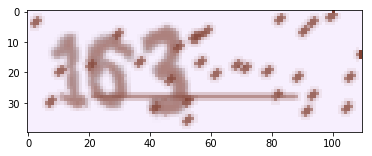

In [4]:
img, b = next(myGenerator(1))
print(numpy.round(b,2))
imshow(img[0])

In [5]:
def custom_loss(y_true, y_pred):
    # use only valid positions
    mask = tf.to_float(y_true[...,0] > 0)
    loss_confidence = mean_squared_error(tf.sigmoid(y_pred[...,0]), y_true[...,0])
    loss_category = tf.reduce_sum(mask*mean_squared_error(y_true[...,1:-1], tf.nn.softmax(y_pred[...,1:-1])), axis=-1)
    loss_shift = mean_squared_error(y_true[...,-1], mask*tf.sigmoid(y_pred[...,-1]))
    loss = alpha_conf*loss_confidence+alpha_class*loss_category + alpha_shift*loss_shift
    return loss

In [6]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)

model = Sequential()
model.add(Conv2D(8, (3, 3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Conv2D(12, (1, 1), input_shape=input_shape, padding='same'))
model.add(AveragePooling2D(pool_size=(3, 1)))
model.add(Reshape((13, 12)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 40, 110, 8)        224       
_________________________________________________________________
activation_1 (Activation)    (None, 40, 110, 8)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 55, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 55, 16)        1168      
_________________________________________________________________
activation_2 (Activation)    (None, 20, 55, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 27, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 27, 32)        4640      
__________

In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [8]:
adam = Adam(lr=1e-3)
model.compile(loss=custom_loss,
              optimizer=adam)

In [9]:
if (os.path.isfile('model_yolo.h5')):
    model = load_model('model_yolo.h5', custom_objects={'custom_loss': custom_loss})

In [10]:
history = model.fit_generator(
    myGenerator(batch_size),
    steps_per_epoch=100000 // batch_size,
    epochs=epochs,
    validation_data=myGenerator(batch_size),
    validation_steps=30000 // batch_size,
    callbacks=[es]
)


Epoch 1/1
1562/1562 [==============================] - 176s 112ms/step - loss: 0.2858 - val_loss: 0.2819


In [11]:
model.save("model_yolo.h5")

In [12]:
def show_img(img):
    imshow(numpy.asarray(img, dtype='float32') / 255) 

In [13]:
def decode_output(p, boxes_in):
    thr = 0.5
    thr2 = 10
    def get_boxes(a):
        boxes = []
        idx = numpy.where(a>thr)[0]
        while(len(idx)>0):
            m = numpy.argmax(a[idx])
            m_x = boxes_in[idx[m]]
            boxes.append(idx[m])
            idx = numpy.delete(idx, numpy.where((boxes_in[idx] < m_x+thr2)&(boxes_in[idx] > m_x-thr2)))
        return boxes
    a = numpy.full(10, -1)
    for d in range(10):
        b = get_boxes(p[:, d])
        a[b]=d
    a = numpy.delete(a, numpy.where(a==-1))
    return a.tolist()

In [14]:
def decode_output(confidence, box_shift, digit):
    thr = 0.5
    
    ret_dig = []
    ret_box = []
    
    ditits_bb = (box_shift-0.5)*2*position_width + (0.5+numpy.arange(positions))*position_width
    
    while 1:
        max_confidence = numpy.argmax(confidence)
        if(confidence[max_confidence] < thr):
            break
        max_pos = ditits_bb[max_confidence]

        ret_dig.append(digit[max_confidence])
        ret_box.append(ditits_bb[max_confidence])

        merge_box = numpy.where(numpy.abs(ditits_bb-max_pos) < digit_width/2)
        confidence[merge_box] = 0
    if(len(ret_box)):
        ret_box, ret_dig = zip(*sorted(zip(ret_box, ret_dig)))
    
    return (ret_dig, ret_box)

In [15]:
def draw_boxes(img, boxes, digits):
    img_out = img.copy()
    draw = PIL.ImageDraw.Draw(img_out)
    for i in range(len(boxes)):
        color = numpy.random.randint(0, 255, 3)
        x = boxes[i]
        draw.polygon([
                (x-digit_width/2, 3), 
                (x+digit_width/2, 3), 
                (x+digit_width/2, digit_height-3), 
                (x-digit_width/2, digit_height-3)
            ], 
            outline=(color[0], color[1], color[2], 0))
        draw.text((x-digit_width/2+2, 5), str(digits[i]), fill=(0,0,0,128))
    return img_out

digits: (9, 2, 3)


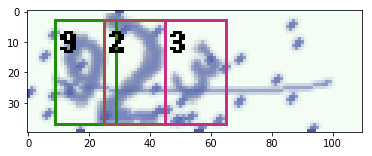

In [16]:
img, b, d, img_raw = next(myGenerator(1, 1))
prediction = model.predict(img)
confidence = K.eval(tf.nn.sigmoid(prediction[0, :, 0]))
box_shift = K.eval(tf.nn.sigmoid(prediction[0, :, -1]))
digit = K.eval(tf.nn.softmax(prediction[0, :, 1:-1]))
digit_predict = numpy.argmax(digit, -1)

(digits, digit_pos) = decode_output(confidence, box_shift, digit_predict)
img_out = draw_boxes(img_raw[0], digit_pos, digits)
print("digits:", digits)
show_img(img_out)

In [18]:
g = myGenerator(batch_size, 1)
N = 1000 // batch_size
e = 0

for i in range(N):
    img, b, d, img_raw = next(g)
    prediction = model.predict(img)
    confidence = K.eval(tf.nn.sigmoid(prediction[:, :, 0]))
    box_shift = K.eval(tf.nn.sigmoid(prediction[:, :, -1]))
    digit = K.eval(tf.nn.softmax(prediction[:, :, 1:-1]))
    digit_predict = numpy.argmax(digit, -1)
    
    for q in range(batch_size):
        (digits, digit_pos) = decode_output(confidence[q], box_shift[q], digit_predict[q])

        if(list(d[q])!=list(digits)):
            e += 1
            print((d[q], digits))
print("Accuracy %.4f" % (1-e/(N*batch_size)))

([2, 6, 4], (2, 6, 7))
([0, 4, 7], (0, 9, 7))
([1, 2, 1], (1, 1))
([8, 9, 8], (8, 9, 3))
([6, 2, 0], (6, 0))
([8, 7, 2], (5, 7, 2))
([6, 9, 9], (0, 9, 9))
([1, 4, 4], (1, 4))
([1, 9, 0], (7, 9, 0))
([0, 9, 4], (0, 9, 7))
([3, 1, 8], (3, 7, 8))
([2, 7, 5], (7, 7, 5))
([0, 5, 3], (8, 5, 3))
([6, 6, 4], (6, 6, 1))
([7, 0, 0], (1, 0, 0))
([4, 3, 1], (4, 1))
([4, 3, 2], (4, 3))
([5, 6, 6], (5, 6))
([1, 5, 8], (5, 8))
([4, 7, 9], (4, 9))
([0, 0, 7], (0, 6, 7))
([0, 1, 9], (0, 9))
([2, 8, 2], (2, 2))
([1, 8, 9], (1, 8, 3))
([7, 4, 0], (7, 4, 8))
([4, 9, 4], (4, 9, 1))
([7, 8, 8], (1, 8, 8))
([6, 2, 2], (6, 2))
([4, 1, 4], (4, 1))
([1, 6, 4], (3, 6, 4))
([5, 1, 7], (5, 7, 7))
([1, 0, 1], (1, 8, 1))
([0, 8, 2], (0, 8, 7))
([9, 8, 0], (9, 8, 9))
([8, 9, 8], (9, 8))
([0, 6, 1], (8, 6, 1))
([8, 2, 0], (8, 1, 0))
([5, 0, 0], (5, 0, 9))
([6, 0, 8], (6, 9, 8))
([0, 8, 3], (0, 3))
Accuracy 0.9583
